In [7]:
# imports and clear session
import numpy as np      
import pandas as pd     
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from keras.preprocessing import image
from sklearn import metrics

tf.keras.backend.clear_session()


In [8]:
# define dataset paths
main_path = '/kaggle/input/main-dataset/ND'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'val')
test_dir  = os.path.join(main_path, 'test')


In [9]:
# utility to list images
def list_images(directory, ext='*.jpg'):
    return glob.glob(os.path.join(directory, '**', ext), recursive=True)

test_fake_path = os.path.join(test_dir, 'fake')
test_real_path = os.path.join(test_dir, 'real')

print("\nImmediate subfolders in train:")
print(os.listdir(train_dir))
print("\nImmediate subfolders in valid:")
print(os.listdir(valid_dir))
print("\nImmediate subfolders in test:")
print(os.listdir(test_dir))



Immediate subfolders in train:
['fake', 'real']

Immediate subfolders in valid:
['fake', 'real']

Immediate subfolders in test:
['fake', 'real']


In [10]:
# build DataFrame of all image paths and labels
images_df = {"folder": [], "image_path": [], "label": []}

for folder in os.listdir(main_path):
    split_path = os.path.join(main_path, folder)
    if os.path.isdir(split_path):
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if os.path.isdir(label_path):
                image_files = glob.glob(os.path.join(label_path, '**', '*.jpg'), recursive=True)
                for img_path in image_files:
                    images_df["folder"].append(folder)
                    images_df["image_path"].append(img_path)
                    images_df["label"].append(label)

images_df = pd.DataFrame(images_df)

real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

print("Real Images Count:\n", real_grouped_df.size())
print("Fake Images Count:\n", fake_grouped_df.size())


Real Images Count:
 Series([], dtype: int64)
Fake Images Count:
 Series([], dtype: int64)


In [11]:
# ImageDataGenerators
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True
)

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)


In [12]:
# create generators
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)


Found 119254 images belonging to 2 classes.
Found 34024 images belonging to 2 classes.
Found 17082 images belonging to 2 classes.


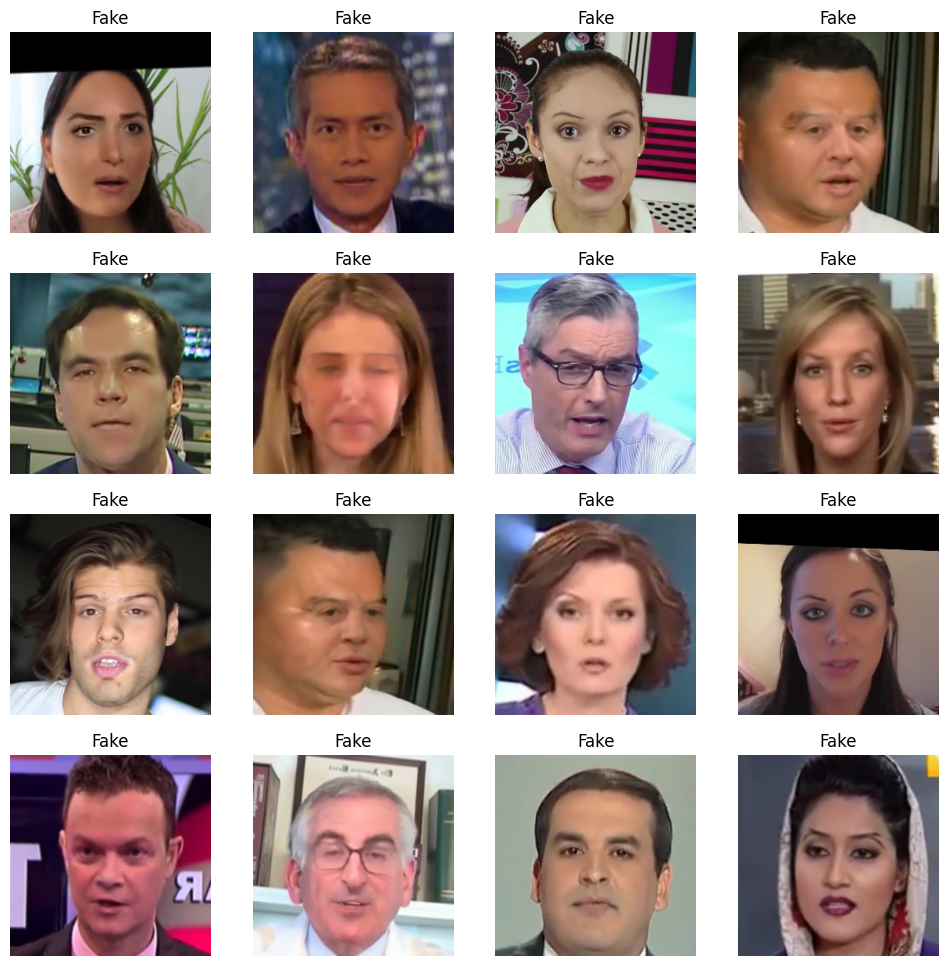

In [13]:
# visualize a batch
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.axis('off')
        plt.title("Fake" if label[i] == 0 else "Real")

img_batch, lbl_batch = next(train_ds)
plot_images(img_batch, lbl_batch)


In [14]:
# inspect batch values and shapes
for img, label in train_ds:
    print("Example image values:", img[0])
    print("Example label:", label[0])
    break

for img, label in train_ds:
    print("Image batch shape:", img.shape)
    print("Label batch shape:", label.shape)
    break

print("Class indices:", train_ds.class_indices)


Example image values: [[[0.74509805 0.19215688 0.25882354]
  [0.74509805 0.19215688 0.25882354]
  [0.7411765  0.19215688 0.25882354]
  ...
  [0.68235296 0.23137257 0.26666668]
  [0.6862745  0.23137257 0.26666668]
  [0.6862745  0.23529413 0.27450982]]

 [[0.7607844  0.19215688 0.25490198]
  [0.7607844  0.19215688 0.25490198]
  [0.7607844  0.19215688 0.25882354]
  ...
  [0.7019608  0.23529413 0.2627451 ]
  [0.7019608  0.23529413 0.2627451 ]
  [0.7019608  0.23529413 0.27058825]]

 [[0.7686275  0.18823531 0.2509804 ]
  [0.76470596 0.19215688 0.2509804 ]
  [0.76470596 0.19215688 0.2509804 ]
  ...
  [0.72156864 0.23529413 0.26666668]
  [0.72156864 0.2392157  0.27058825]
  [0.7254902  0.2392157  0.27450982]]

 ...

 [[0.00392157 0.03137255 0.00784314]
  [0.00784314 0.00784314 0.00784314]
  [0.01568628 0.         0.01176471]
  ...
  [0.03137255 0.00784314 0.        ]
  [0.01960784 0.01176471 0.01176471]
  [0.01568628 0.01176471 0.03137255]]

 [[0.00392157 0.02745098 0.00784314]
  [0.00784314 0

In [15]:
# define Xception + Bi‑LSTM model with tuned hyperparameters
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Reshape, Bidirectional, LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.optimizers import Adam

input_shape = (256, 256, 3)

def get_model(input_shape):
    inp = tf.keras.Input(shape=input_shape)
    # Xception backbone
    backbone = Xception(weights='imagenet', include_top=False, input_tensor=inp)
    # feature map output, e.g. (None, 8, 8, 2048)
    x = backbone.output
    # reshape spatial dims into a sequence of 64 timesteps
    x = Reshape((64, 2048))(x)
    # Bidirectional LSTM head
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    # classification head
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy']
    )
    return model

model_ft = get_model(input_shape)
model_ft.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 127, 127, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 127, 127, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 125, 125, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 125, 125, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 125, 125, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 125, 125, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 125, 125, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 125, 125, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 63, 63, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 63, 63, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 23,224,873 (88.60 MB)

 Trainable params: 23,169,321 (88.38 MB)

 Non-trainable params: 55,552 (217.00 KB)

In [16]:
# callbacks
checkpoint_filepath = "model_cp.weights.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3
)


In [17]:
# train
history_ft = model_ft.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745049885.790084     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


1864/1864 ━━━━━━━━━━━━━━━━━━━━ 2210s 1s/step - accuracy: 0.8573 - loss: 0.3147 - val_accuracy: 0.9338 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 2/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 2021s 1s/step - accuracy: 0.9870 - loss: 0.0384 - val_accuracy: 0.9469 - val_loss: 0.1931 - learning_rate: 1.0000e-04
Epoch 3/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 1999s 1s/step - accuracy: 0.9924 - loss: 0.0218 - val_accuracy: 0.9531 - val_loss: 0.1901 - learning_rate: 1.0000e-04
Epoch 4/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 2018s 1s/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.9236 - val_loss: 0.2820 - learning_rate: 1.0000e-04
Epoch 5/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 1994s 1s/step - accuracy: 0.9951 - loss: 0.0137 - val_accuracy: 0.9548 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 6/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 2021s 1s/step - accuracy: 0.9949 - loss: 0.0127 - val_accuracy: 0.9457 - val_loss: 0.2165 - learning_rate: 1.0000e-04
Epoch 7/20
1864/1864 ━━━━━━━━━━━━━━━━━━━━ 2020s 1s/

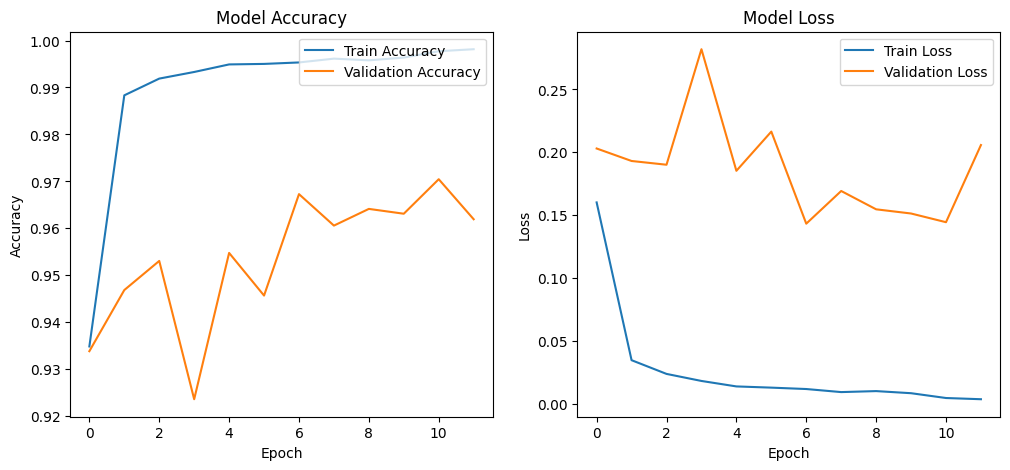

In [18]:
# plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_ft.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_ft.history['loss'], label='Train Loss')
plt.plot(history_ft.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [19]:
# evaluate on test set
test_loss, test_acc = model_ft.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


267/267 ━━━━━━━━━━━━━━━━━━━━ 187s 700ms/step - accuracy: 0.9594 - loss: 0.1770
Test Loss: 0.201680526137352
Test Accuracy: 0.9566795229911804


In [20]:
# reload best weights and re-evaluate
model = get_model(input_shape)
model.load_weights('/kaggle/working/model_cp.weights.h5')

test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss after restoring best weights:", test_loss)
print("Test Accuracy after restoring best weights:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 334 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


267/267 ━━━━━━━━━━━━━━━━━━━━ 98s 354ms/step - accuracy: 0.9594 - loss: 0.1770
Test Loss after restoring best weights: 0.201680526137352
Test Accuracy after restoring best weights: 0.9566795229911804


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


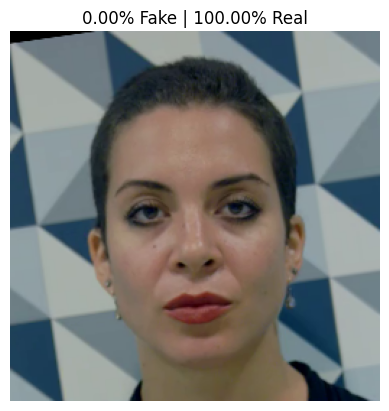

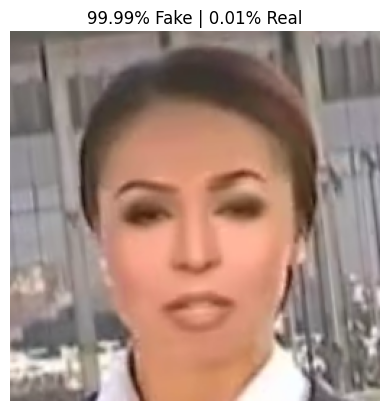

In [21]:
# single-image predictions examples
# Real example
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/main-dataset/ND/test/real/actors_01__talking_against_wall/000.png',
    target_size=(256, 256, 3)
)
plt.imshow(test_image); plt.axis('off')
test_arr = np.expand_dims(tf.keras.preprocessing.image.img_to_array(test_image)/255., 0)
res = model.predict(test_arr)
plt.title(f"{100*(1-res[0][0]):.2f}% Fake | {100*res[0][0]:.2f}% Real");

# Fake example
test_image = tf.keras.preprocessing.image.load_img(
    '/kaggle/input/main-dataset/ND/test/fake/df_007_132/000.png',
    target_size=(256, 256, 3)
)
plt.figure(); plt.imshow(test_image); plt.axis('off')
test_arr = np.expand_dims(tf.keras.preprocessing.image.img_to_array(test_image)/255., 0)
res = model.predict(test_arr)
plt.title(f"{100*(1-res[0][0]):.2f}% Fake | {100*res[0][0]:.2f}% Real");


267/267 ━━━━━━━━━━━━━━━━━━━━ 90s 330ms/step


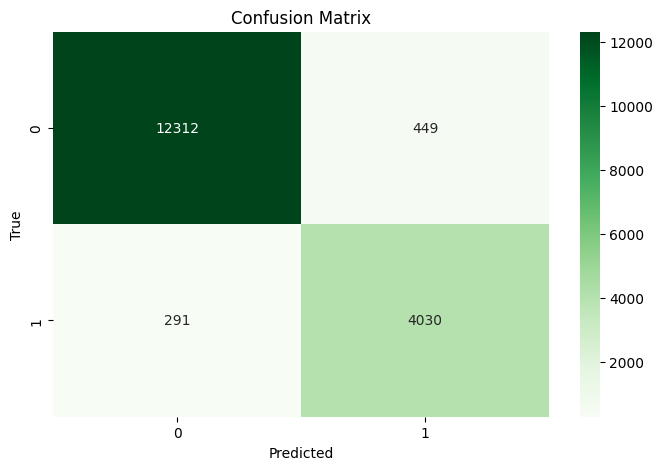

Test Accuracy: 0.9567


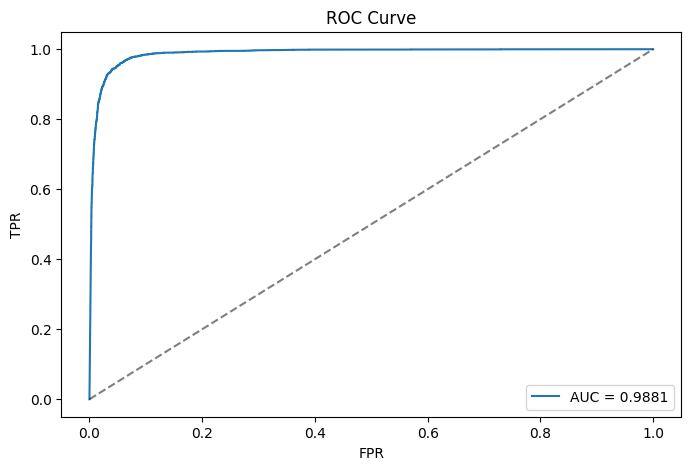

Precision: 0.8998
Recall:    0.9327
F1 Score:  0.9159

Classification Report:
              precision    recall  f1-score   support

           0     0.9769    0.9648    0.9708     12761
           1     0.8998    0.9327    0.9159      4321

    accuracy                         0.9567     17082
   macro avg     0.9383    0.9487    0.9434     17082
weighted avg     0.9574    0.9567    0.9569     17082



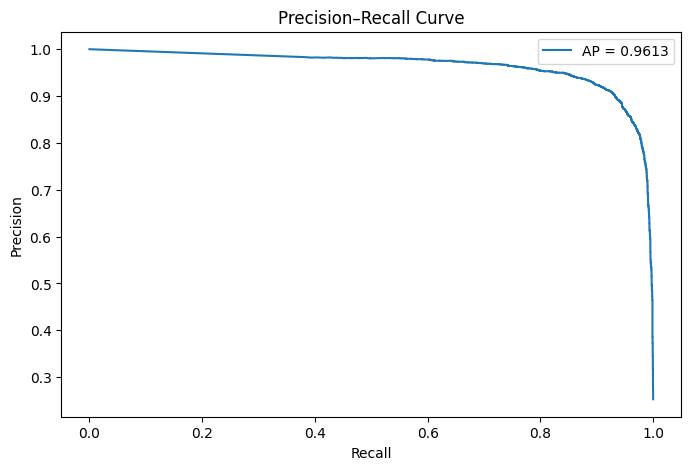

In [22]:
# classification metrics
predicted_proba = model.predict(test_ds)
predicted_labels = predicted_proba.round().astype(int).flatten()
true_labels = test_ds.classes

plt.figure(figsize=(8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels),
            annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

acc = metrics.accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {acc:.4f}")

fpr, tpr, _ = metrics.roc_curve(true_labels, predicted_proba)
auc = metrics.roc_auc_score(true_labels, predicted_proba)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(loc="lower right")
plt.show()

precision = metrics.precision_score(true_labels, predicted_labels)
recall    = metrics.recall_score(true_labels, predicted_labels)
f1        = metrics.f1_score(true_labels, predicted_labels)
print(f"Precision: {precision:.4f}\nRecall:    {recall:.4f}\nF1 Score:  {f1:.4f}\n")

print("Classification Report:")
print(metrics.classification_report(true_labels, predicted_labels, digits=4))

pr_prec, pr_rec, _ = metrics.precision_recall_curve(true_labels, predicted_proba)
avg_prec = metrics.average_precision_score(true_labels, predicted_proba)
plt.figure(figsize=(8,5))
plt.plot(pr_rec, pr_prec, label=f"AP = {avg_prec:.4f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall Curve"); plt.legend(loc="upper right")
plt.show()


In [23]:
# save final model
model.save('deepfake_detection_model.h5')
print("Final model saved successfully!")

Final model saved successfully!
